In [1]:
import seaborn as sns
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as maths
"Done with loading packages"

'Done with loading packages'

# Exploratory Data Analysis

Time to have a bit of a play with the data.

I'll abbreviate the classes as some of them are quite long.

In [2]:
df = pd.read_csv("../data/zone_data.csv")

# Abbreviate classes
classes = pd.unique(df['class'])
classes_short = ["".join([w[0] for w in cl.split()]) for cl in classes]
df['class'].replace(to_replace=classes, value=classes_short, inplace=True)
class_dict = {cs: c for cs, c in zip(classes_short,classes)}

class_dict

{'BP': 'Bloodborne Pathogens',
 'DCRRaTtPoHC': 'Direct Contact, Respiratory Routes, and Through the Provision of Health Care',
 'EFaWD': 'Enteric, Foodborne, and Waterborne Diseases',
 'STI': 'Sexually Transmitted Infections',
 'VPD': 'Vaccine Preventable Diseases',
 'VaOZ': 'Vectorborne and Other Zoonoses'}

## Data set-up

Let's create a pivoted form of the data.

In [31]:
# Wide-to-long (bring zone as an index)
dfmelted = pd.melt(df, id_vars=['year', 'class', 'condition'], var_name="location")

# Separate zone & n/rate
dfmelted[['zone','data_type']] = dfmelted.location.str.split("_", expand=True)
dfmelted.drop(['location'], axis=1, inplace=True)

# Zone is 1st 3 chars of each zone
dfmelted['zone'] = ["".join(w[1:4]) for w in dfmelted['zone'].str.split("")]
dfmelted['zone']=dfmelted['zone'].replace(to_replace="tot", value="all")

# Long-to-wide on value and data-type
dfrm = pd.pivot(dfmelted, index=["year","class","condition","zone"], columns=["data_type"], values="value").reset_index()
dfrm.head()

data_type,year,class,condition,zone,n,rate
0,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),all,3.0,0.3
1,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),cen,3.0,0.7
2,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),eas,0.0,0.0
3,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),nor,0.0,0.0
4,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),wes,0.0,0.0


## Initial Plots

Let's start with a simple plot to see the rates of different classes in each health zone. I've already `melt`ed the data, filtered for `"rate"` and removed `"condition" == "total"`.

Here I will generate a simple cat plot, faceted by disease `"class"` so that we can compare rates across the zones.

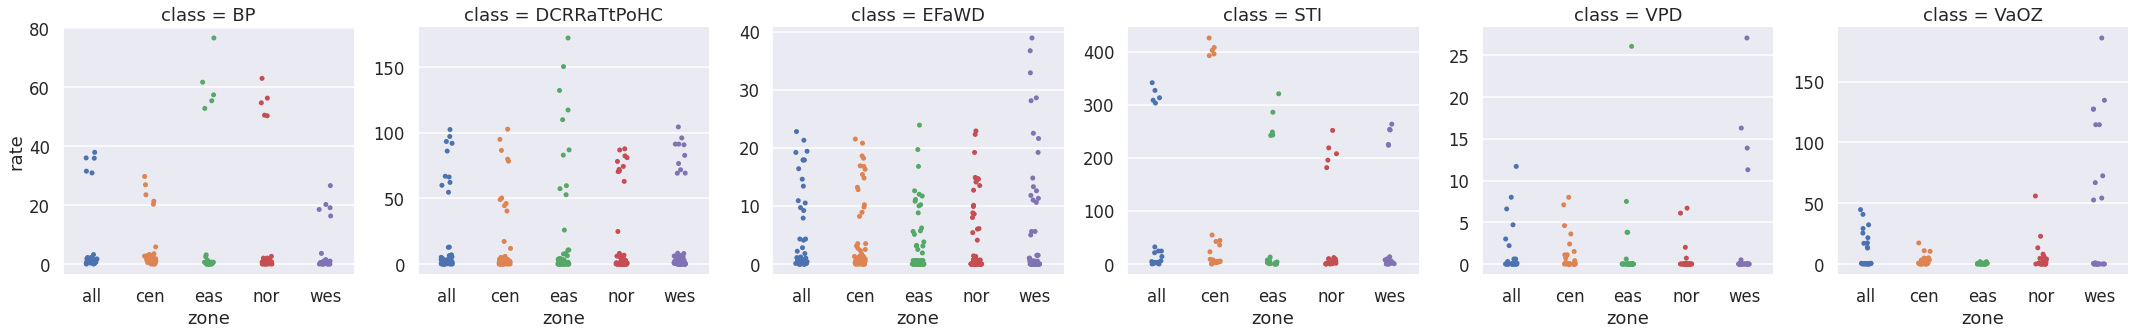

In [12]:
sns.set_theme(style="darkgrid", color_codes=True)
sns.set_context("talk")
sns.catplot(
	x="zone", 
	y="rate", 
	col="class", 
	sharey=False,
	data=dfrm.query("condition != 'total'")
)

### Thoughts

Immediately I can see that STIs are at a higher rate in the Central zone - which contains the largest population and population density. In particular it looks like one of the STI conditions is consistently more prevalent.

Western zone has higher rates of VaOZ, whilst Eastern zone has higher rates of DCRRaTtPoHC.

Let's break things down a bit more.

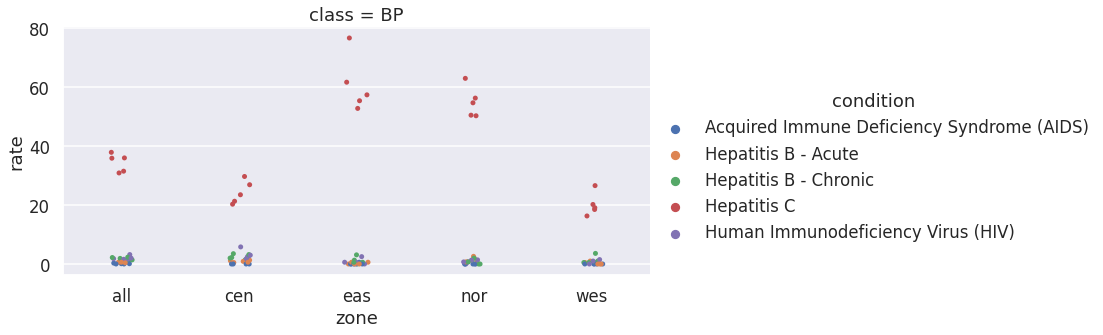

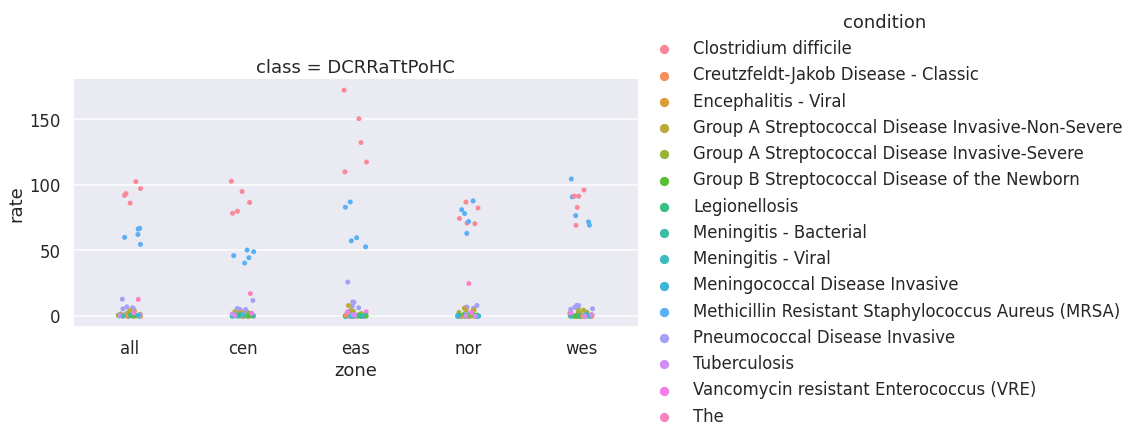

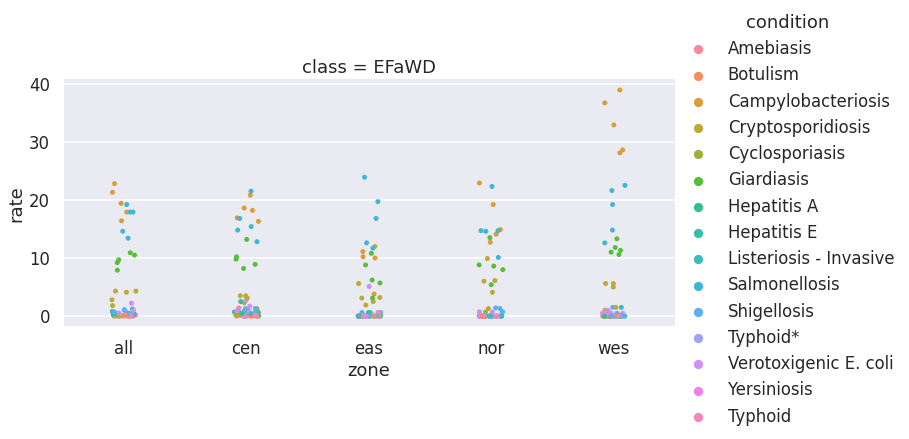

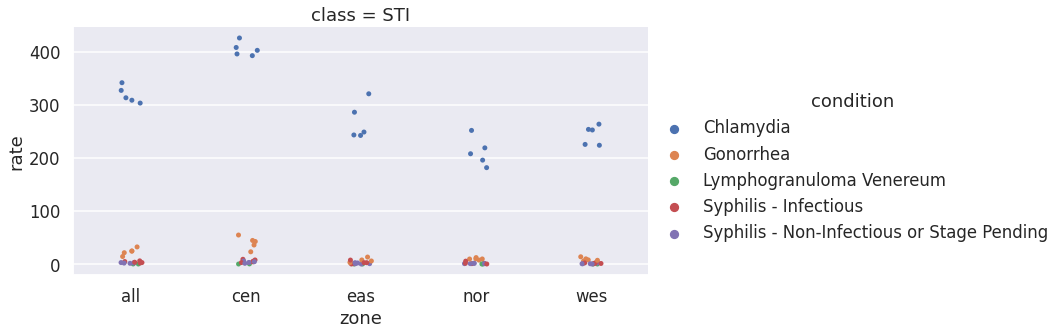

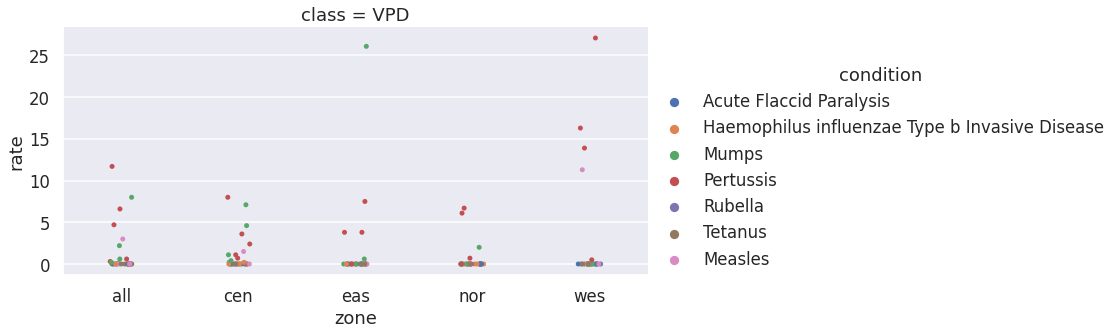

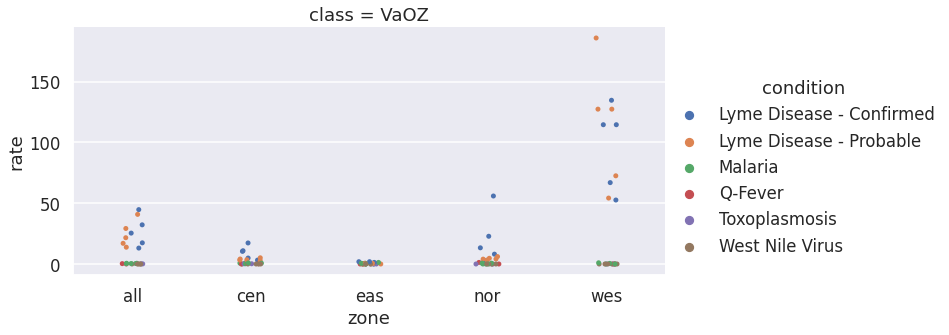

In [5]:
for c in classes_short:
	sns.catplot(
		x="zone",
		y="rate",
		col="class",
		hue="condition",
		aspect=2,
		data=dfrm[dfrm['class']==c].query("condition != 'total'")
	)
	

Breaking down into classes as above I identify that the heightened rates of diseases classified as VaOZ in the Western Zone are primarily due to Lyme Disease. This is actually what I expected after reading recent *tweets* about ticks in the province, noting that they are most often found in that part of the province. 

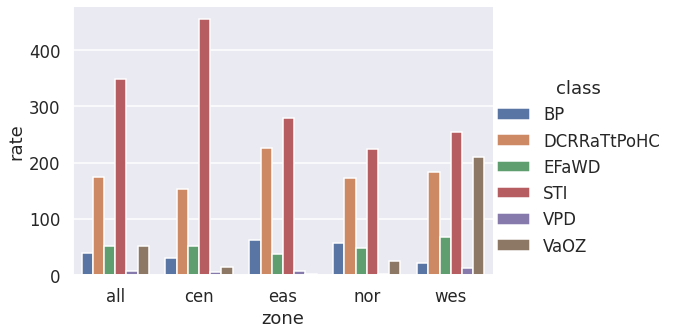

In [6]:
sns.catplot(
	kind="bar",
	x="zone", 
	y="rate", 
	hue="class", 
	aspect=1.5, 
	data=dfrm.query("condition == 'total'").groupby(["class", "zone"]).mean().reset_index()
)


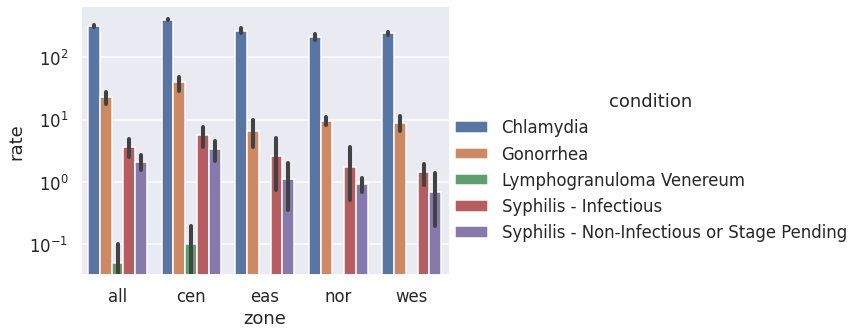

In [7]:
sns.catplot(
	kind="bar", 
	x="zone", 
	y="rate", 
	hue="condition", 
	aspect=1.5, 
	log=True,
	data=dfrm[dfrm['class']=="STI"].query("condition != 'total'")
)

I now see that Chlamydia is very high throughout the province with Gonorrhea also prevalent. The rates of both these are higher in Central zone than the other three zones, and for the province. 

## Comparing Zones

Here I center and scale the rates, they are first grouped together by year, class, and condition (**Not zone**). If we plot densities for these scaled rates and differentiate them by zone we can hopefully see differences in how disease classes are handled by zone. 

The centering and scaling brings the data to the same normalisation, so it should be reasonably comparible.

In [15]:
dfrm['scaled_rate'] = dfrm.groupby(["year","condition","class"])["rate"].apply(lambda x: (x-np.mean(x))/np.std(x))
dfrm.head(10)

data_type,year,class,condition,zone,n,rate,scaled_rate
0,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),all,3.0,0.3,0.362738
1,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),cen,3.0,0.7,1.813691
2,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),eas,0.0,0.0,-0.725476
3,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),nor,0.0,0.0,-0.725476
4,2015,BP,Acquired Immune Deficiency Syndrome (AIDS),wes,0.0,0.0,-0.725476
5,2015,BP,Hepatitis B - Acute,all,9.0,1.0,0.119844
6,2015,BP,Hepatitis B - Acute,cen,5.0,1.1,0.269650
7,2015,BP,Hepatitis B - Acute,eas,0.0,0.0,-1.378209
8,2015,BP,Hepatitis B - Acute,nor,3.0,2.0,1.617898
9,2015,BP,Hepatitis B - Acute,wes,1.0,0.5,-0.629183


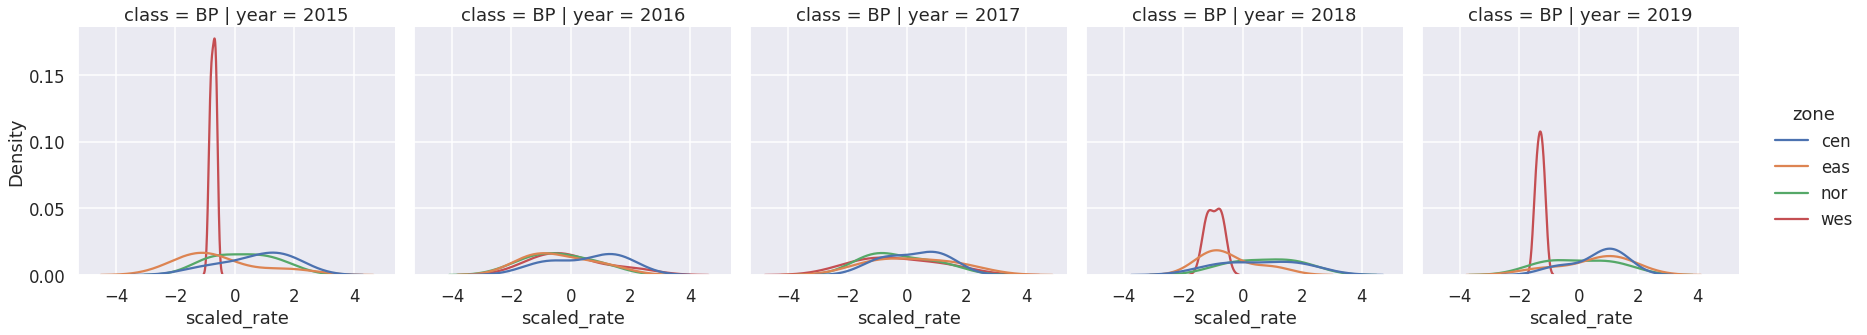

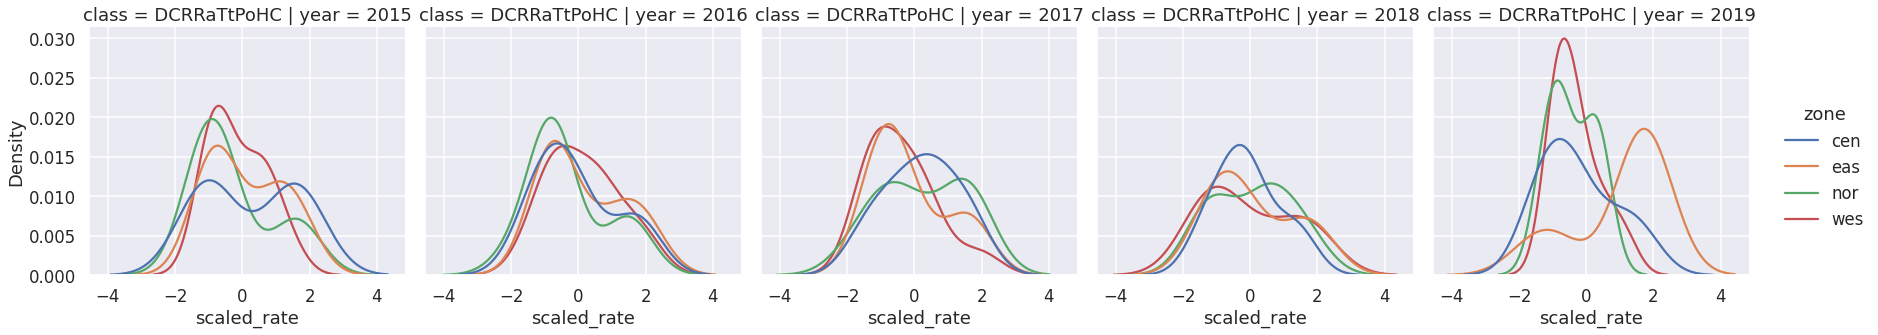

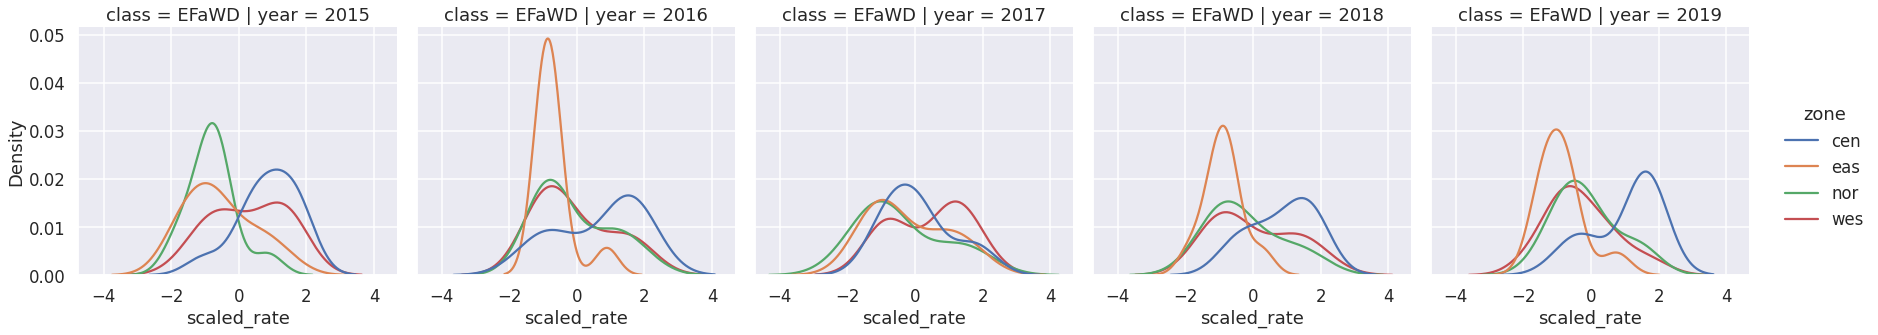

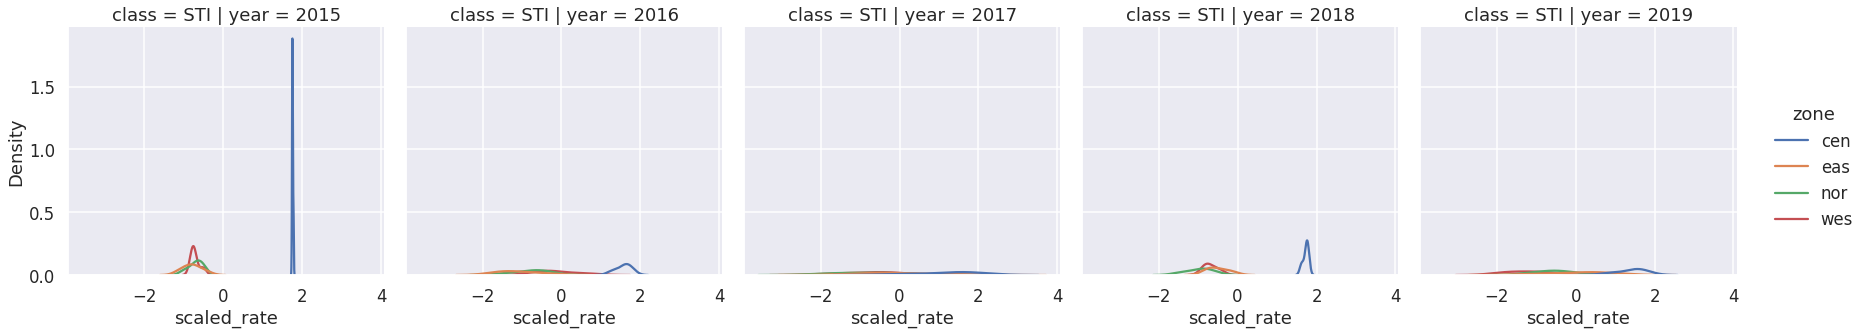

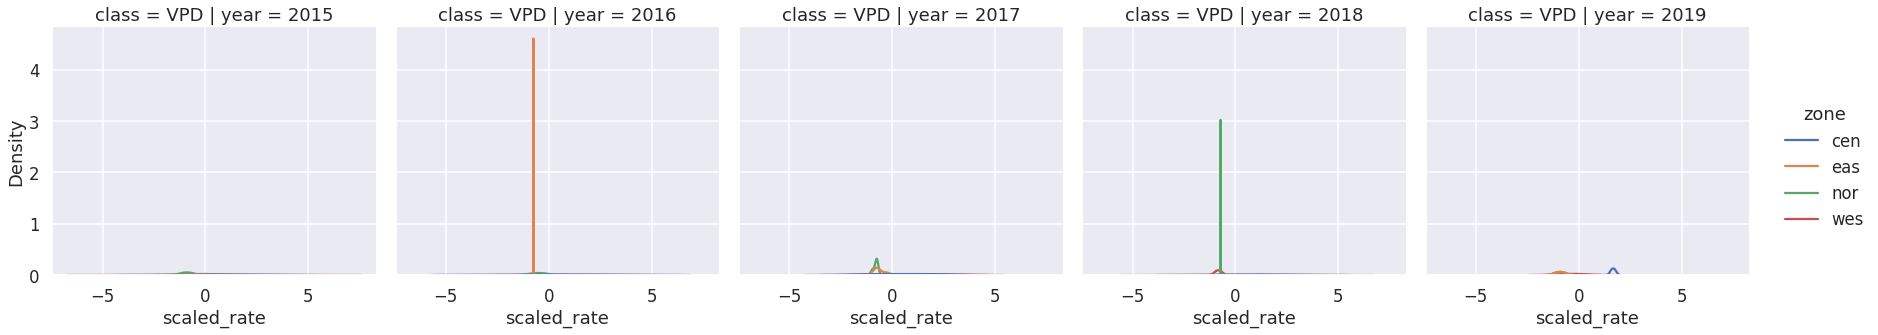

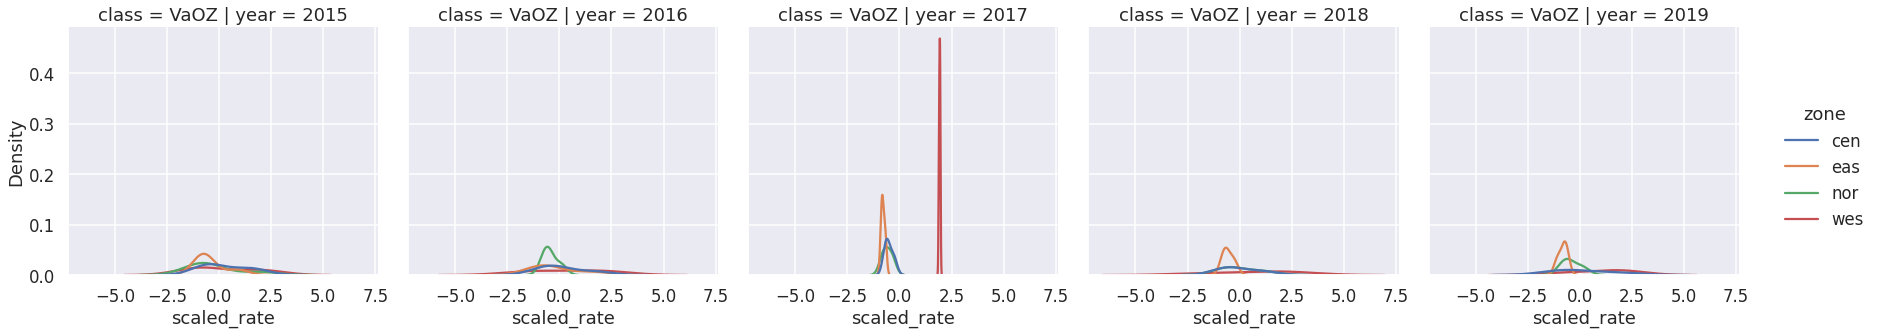

In [16]:
for c in classes_short:
	sns.displot(
		kind="kde", 
		x="scaled_rate", 
		row="class",
		col="year",
		hue="zone", 
		data=dfrm[dfrm['class'] == c].query("condition != 'total' & zone != 'all'")
	)

The plot for `class="DCRRaTtPoHC"` in 2019 is interesting and stands out as being different to the others for this class. The class refers to *"Direct Contact, Respiratory Routes, and Through the Provision of Health Care"*. The plot suggests that rates of this classification are higher in Eastern zone in 2019 then they are for any other year or zone. It would be interesting to see what has changed in the zone, or it's management of these diseases in 2019, or whether it is just an random anomaly. This peculiarity is also evident in the first bar plot.

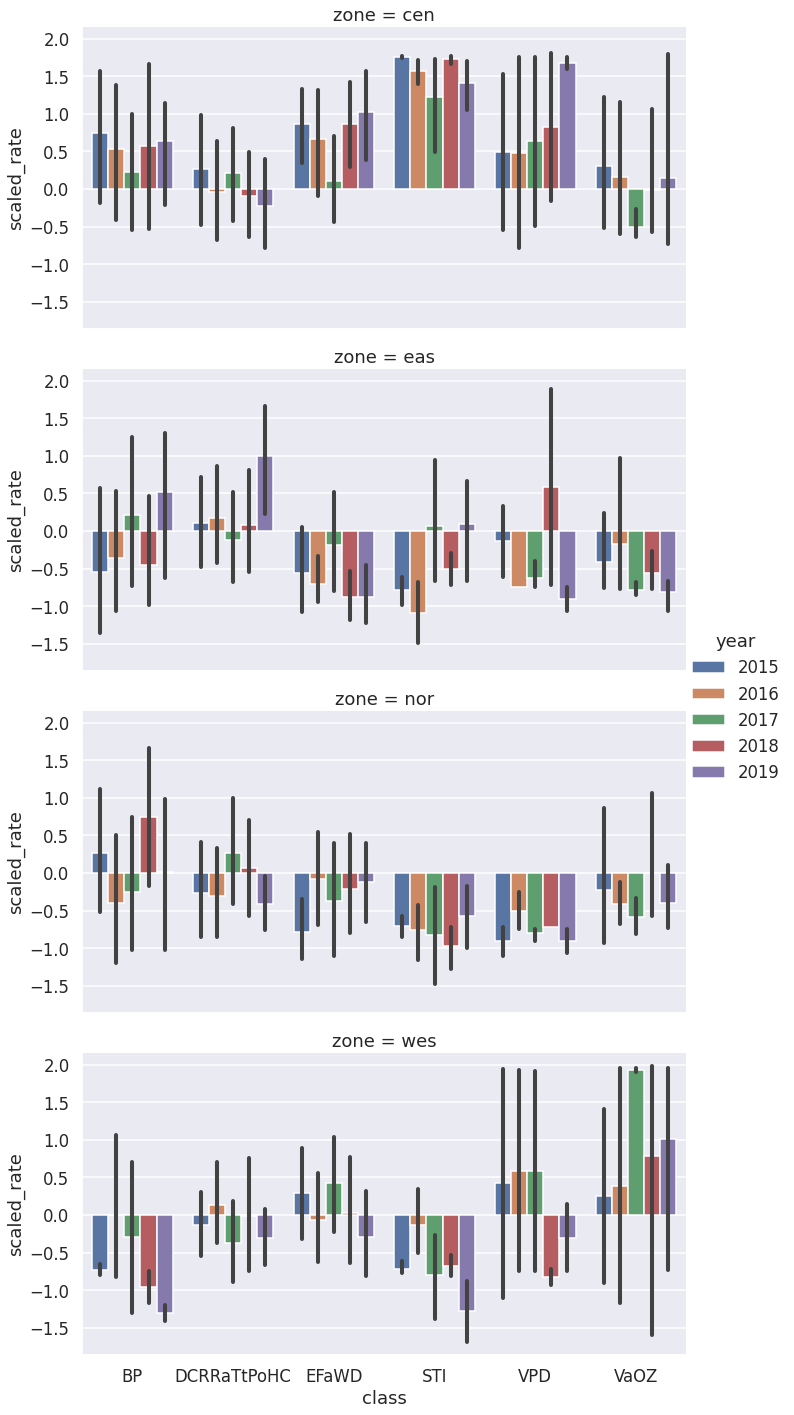

In [10]:
sns.catplot(
	kind="bar",
	x="class",
	y="scaled_rate",
	hue="year",
	aspect=2,
	row="zone",
	data=dfrm.query("condition != 'total' & zone != 'all'")
)

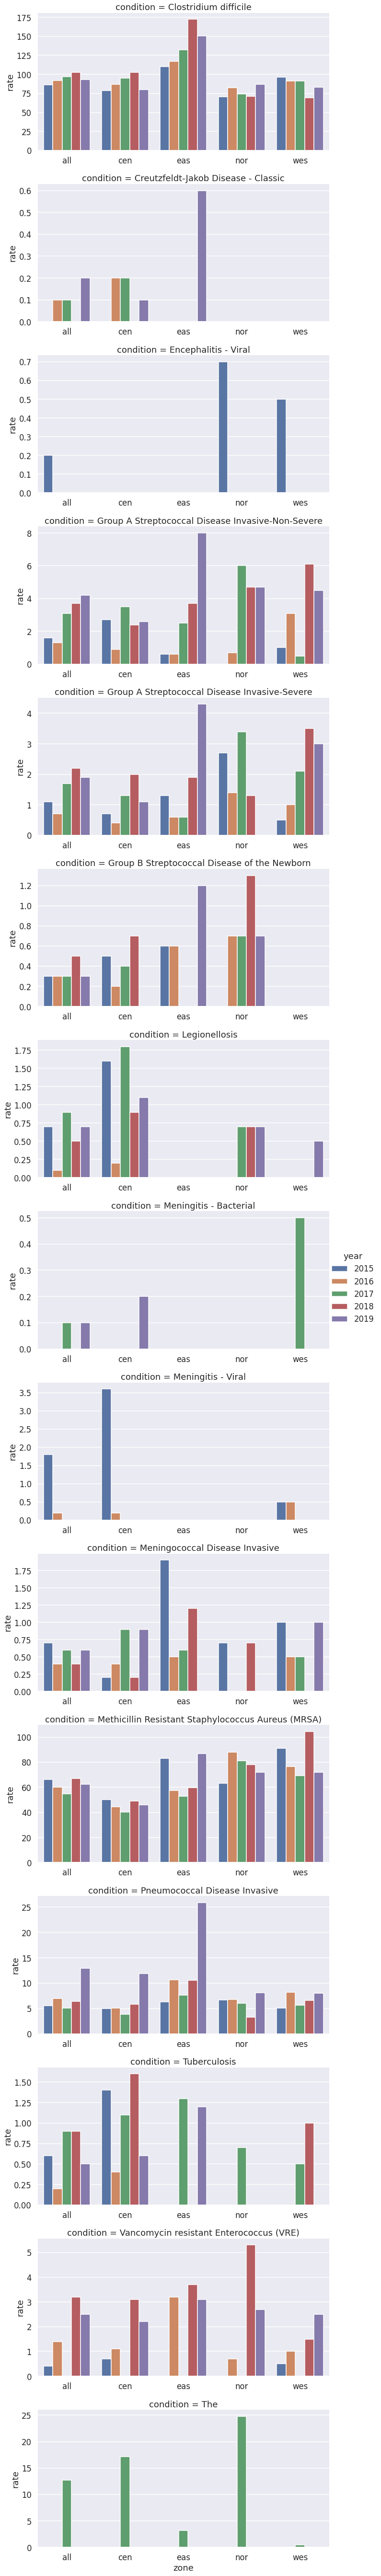

In [25]:
sns.catplot(
	kind="bar",
	x="zone",
	y="rate",
	hue="year",
	row="condition",
	# col="zone",
	sharey=False,
	sharex=False,
	aspect=2,
	data=dfrm[dfrm['class']=="DCRRaTtPoHC"].query("condition != 'total'")
)